In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyspark.sql.functions as F
import setuptools
from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from sklearn import linear_model, preprocessing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

load_dotenv()

spark = SparkSession.builder.remote(os.getenv('SPARK_HOST')).appName(os.getenv('SPARK_APP_NAME')).getOrCreate()

In [2]:
ROOT = os.getenv('WORKING_DIR') or '.'
taxdf = spark.read.parquet(ROOT + 'data/tax_admin_applied_car_tax_data')
taxdf = taxdf.withColumn('index', F.monotonically_increasing_id()) # add index for joins
taxdf.show(5)

+----------+----------------+---------------+-------------------------------+----------------+-----------+--------------------+-------------+-------+----+-------------+-------+--------------------+----------+------------+---+---------------------+--------------------------+--------+-----+
|      make|           model|model_specifier|condition_h_bad_n_normal_y_good|date_of_decision|date_of_use|odometer_unit_1000km|taxable_value|car_tax| Cm3|driving_power|n_doors|          body_style|drivetrain|transmission| Kw|individual_properties|date_of_first_registration|tax_rate|index|
+----------+----------------+---------------+-------------------------------+----------------+-----------+--------------------+-------------+-------+----+-------------+-------+--------------------+----------+------------+---+---------------------+--------------------------+--------+-----+
|         A|              MG|           NULL|                           NULL|      2022-09-15|       NULL|                 100|   

In [3]:
df = taxdf.drop('model_specifier', 'condition_h_bad_n_normal_y_good', 'n_doors', 'body_style', 'individual_properties')

df = df.withColumn('make', F.lower(df.make))
df = df.withColumn('model', F.lower(df.model))

df = df.withColumnRenamed('odometer_unit_1000km', 'odom')
df = df.withColumn('age', (df['date_of_decision'] - df['date_of_first_registration']).cast('int'))
df = df.withColumn('age2', (df['date_of_decision'] - df['date_of_use']).cast('int'))


df2 = df.select('index', F.coalesce(df['age'], df['age2'], F.lit(0)).alias('c0'))

df = df.join(df2, on='index')
df = df.drop('age', 'age2')
df = df.withColumnRenamed('c0', 'age')

df.printSchema()

root
 |-- index: long (nullable = false)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- date_of_decision: date (nullable = true)
 |-- date_of_use: date (nullable = true)
 |-- odom: integer (nullable = true)
 |-- taxable_value: double (nullable = true)
 |-- car_tax: double (nullable = true)
 |-- Cm3: integer (nullable = true)
 |-- driving_power: string (nullable = true)
 |-- drivetrain: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- Kw: integer (nullable = true)
 |-- date_of_first_registration: date (nullable = true)
 |-- tax_rate: double (nullable = true)
 |-- age: integer (nullable = false)



In [4]:
targets = df.filter((df.age < 6 * 30) & (df.odom < 6) )
targets = targets.withColumn('Y', targets.taxable_value)

targets.show(20)
targets.count()

+----------+-------------+-------------------+----------------+-----------+----+-------------+--------+----+-----------------+----------+------------+----+--------------------------+--------+---+--------+
|     index|         make|              model|date_of_decision|date_of_use|odom|taxable_value| car_tax| Cm3|    driving_power|drivetrain|transmission|  Kw|date_of_first_registration|tax_rate|age|       Y|
+----------+-------------+-------------------+----------------+-----------+----+-------------+--------+----+-----------------+----------+------------+----+--------------------------+--------+---+--------+
|       686|       clever|        celebration|      2022-09-06|       NULL|   1|      74380.0|     0.0|2197|           Diesel|   Etuveto|        NULL| 121|                2022-07-04|    40.0| 64| 74380.0|
|       956|       inzile|               pro4|      2022-09-26|       NULL|   1|      35614.0|     0.0|   0|            Sähkö|  Takaveto|         AUT|  10|                2022-07-1

np.int64(104)

In [5]:
X = df.join(targets.select(['make', 'model', 'Y']), on=['make', 'model'])
X.show(10)

+------+--------------------+-----+----------------+-----------+----+-------------+-------+----+-----------------+----------+------------+---+--------------------------+--------+----+-------+
|  make|               model|index|date_of_decision|date_of_use|odom|taxable_value|car_tax| Cm3|    driving_power|drivetrain|transmission| Kw|date_of_first_registration|tax_rate| age|      Y|
+------+--------------------+-----+----------------+-----------+----+-------------+-------+----+-----------------+----------+------------+---+--------------------------+--------+----+-------+
|  mini|countryman cooper...| 1773|      2022-09-21|       NULL|  58|      23755.0|1282.77|1499|Bensiini ja sähkö|  Neliveto|         AUT|100|                2018-03-05|     5.4|1661|47167.0|
|  mini|countryman cooper...| 1774|      2022-09-12|       NULL|  31|      26851.0|1261.99|1499|Bensiini ja sähkö|  Neliveto|         AUT|100|                2019-02-26|     4.7|1294|47167.0|
|  mini|countryman cooper...| 5719|     

In [6]:
xdf = X.toPandas()

xdf = xdf[['age', 'odom', 'taxable_value', 'Y']]

print(xdf.isna().sum())
xdf = xdf.dropna()

x = xdf[['age', 'odom', 'taxable_value']]
y = xdf['Y']

pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('poly2', PolynomialFeatures(degree=2)),
    ('regressor', linear_model.LinearRegression())
])

cv = KFold(n_splits = 5, shuffle=True, random_state=42)

scores = cross_val_score(pipe, x, y, scoring='neg_mean_squared_error', cv=cv)
print(scores)

pipe.fit(x, y)


age               0
odom             33
taxable_value     0
Y                 0
dtype: int64
[-2.74552714e+08 -2.85847238e+08 -3.29812201e+08 -2.83119263e+08
 -3.08865647e+08]


Pipeline(steps=[('scaler', StandardScaler()), ('poly2', PolynomialFeatures()),
                ('regressor', LinearRegression())])

In [7]:
D = df.select('index', 'age', 'odom', 'taxable_value').toPandas()
D = D.dropna()

d = D[['age', 'odom', 'taxable_value']]

pred_prices = pipe.predict(d)

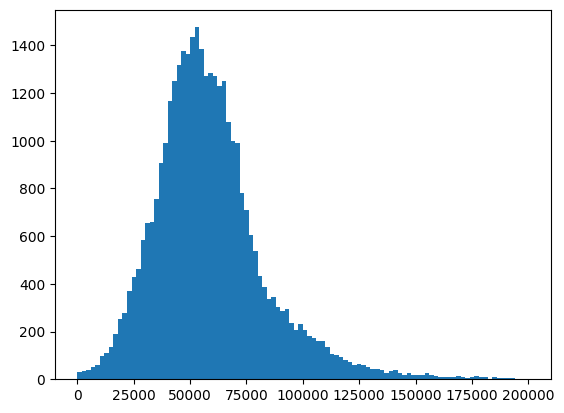

In [8]:
a = pd.DataFrame({'index': D['index'], 'pred_price': pred_prices})
a = a[a.pred_price >= 0] # ~100 prices below 0

plt.hist(a.pred_price, bins=100, range=[0, 200000]);


In [9]:
preddata = spark.createDataFrame(a)
preddata.printSchema()

merged = taxdf.join(preddata, on='index')

merged.write.options(encoding="ISO-8859-1", header=True, delimiter=";").parquet(ROOT + 'data/tax_data_with_price_predictions')

root
 |-- index: long (nullable = true)
 |-- pred_price: double (nullable = true)

